In [ ]:
!pip install onnx onnxruntime

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [15]:
# simple 모델



# MNIST 데이터셋을 위한 간단한 모델 생성
class SimpleMNISTModel(torch.nn.Module):
    def __init__(self):
        super(SimpleMNISTModel, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(28 * 28, 128)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 모델 초기화
model = SimpleMNISTModel()

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.1)  # SGD 옵티마이저

# 예제 데이터 생성 및 DataLoader 설정
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)



In [22]:
!pip install torchsummary

In [24]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


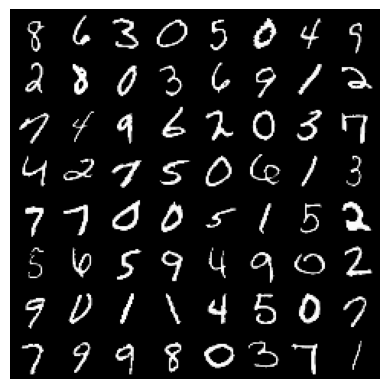

라벨: tensor([8, 6, 3, 0, 5, 0, 4, 9, 2, 8, 0, 3, 6, 9, 1, 2, 7, 4, 9, 6, 2, 0, 3, 7,
        4, 2, 7, 5, 0, 6, 1, 3, 7, 7, 0, 0, 5, 1, 5, 2, 5, 6, 5, 9, 4, 9, 0, 2,
        9, 0, 1, 1, 4, 5, 0, 7, 7, 9, 9, 8, 0, 3, 7, 1])


In [21]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

# 이미지를 시각화하여 보여주는 함수
def imshow(img):
    # 텐서를 넘파이 배열로 변환
    npimg = img.numpy()
    # 이미지를 (batch_size, height, width)에서 (height, width, batch_size)로 변환
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 축 제거
    plt.show()

# 이미지 시각화
imshow(torchvision.utils.make_grid(images))
print('라벨:', labels)

In [ ]:

# 학습률(learning rate)과 손실(loss)을 저장할 리스트
learning_rates = []
losses = []

# 모델 학습
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # 매 100번째 미니배치마다 학습률과 손실을 리스트에 추가
        if i % 100 == 99:
            learning_rates.append(optimizer.param_groups[0]['lr'])
            losses.append(running_loss / 100)
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('학습 완료')

# 모델을 ONNX 형식으로 저장
example_input = torch.randn(1, 1, 28, 28)  # 입력 예제 데이터 생성
torch.onnx.export(model, example_input, "simple_mnist_model.onnx", verbose=True)

print('ONNX 모델 저장 완료')

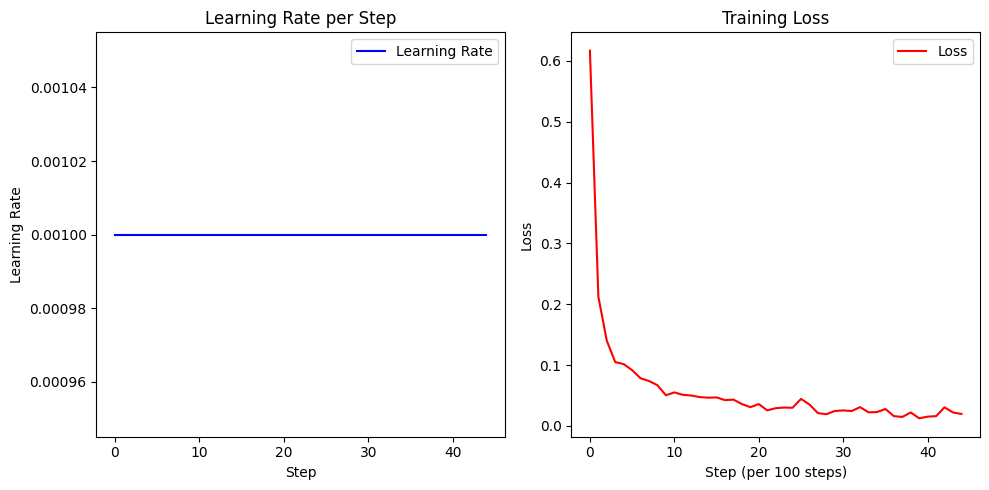

In [14]:


# 학습률과 손실에 대한 그래프 그리기
plt.figure(figsize=(10, 5))

# 학습률 그래프
plt.subplot(1, 2, 1)
plt.plot(learning_rates, label='Learning Rate', color='blue')
plt.title('Learning Rate per Step')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(losses, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Step (per 100 steps)')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torchvision
from torchvision import transforms

# MNIST 데이터셋 불러오기
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# 저장된 ONNX 모델 불러오기
ort_session = ort.InferenceSession("/content/simple_mnist_model.onnx")
input_name = ort_session.get_inputs()[0].name

# 모델 평가하기
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = ort_session.run(None, {input_name: images.numpy()})
        predicted = torch.argmax(torch.tensor(output))
        total += labels.size(0)
        correct += (predicted == labels[0]).sum().item()

accuracy = correct / total
print(f"모델의 정확도: {accuracy * 100:.2f}%")

모델의 정확도: 95.31%


In [1]:
# CNN 모델
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [2]:
# MNIST 데이터셋 불러오기
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 데이터 로더 설정
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 초기화
model = CNN()

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 9912422/9912422 [00:00<00:00, 65846031.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60537578.12it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23577733.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10684536.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 학습률(learning rate)과 손실(loss)을 저장할 리스트
learning_rates = []
losses = []


# 모델 학습
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:
            learning_rates.append(optimizer.param_groups[0]['lr'])
            losses.append(running_loss / 100)
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print('학습 완료')

# 모델을 ONNX 형식으로 저장
example_input = torch.randn(1, 1, 28, 28)  # 입력 예제 데이터 생성
torch.onnx.export(model, example_input, "cnn_mnist_model.onnx", verbose=True)

print('ONNX 모델 저장 완료')

In [ ]:
import torch
import torchvision
from torchvision import transforms

# MNIST 데이터셋 불러오기
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# 저장된 ONNX 모델 불러오기
ort_session = ort.InferenceSession("/content/cnn_mnist_model.onnx")
input_name = ort_session.get_inputs()[0].name

# 모델 평가하기
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        output = ort_session.run(None, {input_name: images.numpy()})
        predicted = torch.argmax(torch.tensor(output))
        total += labels.size(0)
        correct += (predicted == labels[0]).sum().item()

accuracy = correct / total
print(f"모델의 정확도: {accuracy * 100:.2f}%")

모델의 정확도: 98.29%
